In [1]:
import pandas as pd
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
from sklearn.ensemble import AdaBoostRegressor
import numpy as np
from lib.brisque import *
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


#### Data Loading and Target Scaling

In [2]:
image_list_df = pd.read_table('tid2013/mos_with_names.txt',sep=' ',names=['mos_score','filename'])
image_list_df['mos_scaled'] = minmax_scale(image_list_df['mos_score'],feature_range=(0,100))
image_list_df.head()

mos_score      filename  mos_scaled
0    5.51429  I01_01_1.bmp   75.616298
1    5.56757  i01_01_2.bmp   76.380512
2    4.94444  i01_01_3.bmp   67.442738
3    4.37838  i01_01_4.bmp   59.323539
4    3.86486  i01_01_5.bmp   51.957940

#### Build Feature List

In [3]:
filepath = 'tid2013/distorted_images/'
feature_list = []
for i in image_list_df['filename']:
    file = filepath + i
    image = np.array(Image.open(file))
    grey_image = rgb2gray(image)
    grey_image_downsized =  cv2.resize(grey_image,None,fx=1/2,fy=1/2,interpolation=cv2.INTER_CUBIC)
    f_distorted = calculate_brisque_features(grey_image)
    f_distorted_downsized = calculate_brisque_features(grey_image_downsized)
    features = np.concatenate((f_distorted,f_distorted_downsized))
    feature_list.append(features)
image_list_df = pd.concat([image_list_df,pd.DataFrame(feature_list)],axis=1)

#### Build Distoriton type Columns

In [4]:
dist_type = []
count = 0
for name in image_list_df['filename']:
    if name.split('_')[1] == '01':
        dist_type.append(True)
    elif name.split('_')[1] == '08':
        dist_type.append(True)
    elif name.split('_')[1] == '10':
        dist_type.append(True)
    elif name.split('_')[1] == '11':
        dist_type.append(True)
    else:
        dist_type.append(False)
dist_type_df = image_list_df.loc[dist_type]

In [5]:
dist_type = []
count = 0
for name in dist_type_df['filename']:
    if name.split('_')[1] == '01':
        dist_type.append(1)
    else:
        dist_type.append(0)

dist_type_df['GN'] = dist_type

In [6]:
dist_type = []
count = 0
for name in dist_type_df['filename']:
    if name.split('_')[1] == '08':
        dist_type.append(1)
    else:
        dist_type.append(0)

dist_type_df['GB'] = dist_type

In [7]:
dist_type = []
count = 0
for name in dist_type_df['filename']:
    if name.split('_')[1] == '10':
        dist_type.append(1)
    else:
        dist_type.append(0)

dist_type_df['JPEG'] = dist_type

In [8]:
dist_type = []
count = 0
for name in dist_type_df['filename']:
    if name.split('_')[1] == '11':
        dist_type.append(1)
    else:
        dist_type.append(0)

dist_type_df['JPEG2K'] = dist_type

#### Build Classifier For each type of distortion 

#### Guassian Noise

In [9]:
y = dist_type_df['GN']
X = dist_type_df.iloc[:,3:-4]
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)
scale = StandardScaler()
scale.fit(x_train)
x_train_scaled = scale.transform(x_train)
x_test_scaled = scale.transform(x_test)
params = {
    'C': np.linspace(start = 0.001,stop=1,num=50),
    'gamma':np.linspace(start = 0.001,stop=1,num=50)
}
gn_clf = GridSearchCV(SVC(kernel='rbf',probability=True),param_grid = params,n_jobs=-1)
gn_clf.fit(x_train_scaled,y_train)
print('training_score:',gn_clf.score(x_train_scaled,y_train))
print('test_score:',gn_clf.score(x_test_scaled,y_test))

training_score: 0.9970149253731343
test_score: 1.0


#### Guassian Blur

In [11]:
y = dist_type_df['GB']
X = dist_type_df.iloc[:,3:-4]
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)
scale = StandardScaler()
scale.fit(x_train)
x_train_scaled = scale.transform(x_train)
x_test_scaled = scale.transform(x_test)
params = {
    'C': np.linspace(start = 0.001,stop=1,num=50),
    'gamma':np.linspace(start = 0.001,stop=1,num=50)
}
gb_clf = GridSearchCV(SVC(kernel='rbf',probability=True),param_grid = params,n_jobs=-1)
gb_clf.fit(x_train_scaled,y_train)
print('training_score:',gb_clf.score(x_train_scaled,y_train))
print('test_score:',gb_clf.score(x_test_scaled,y_test))

training_score: 0.9611940298507463
test_score: 0.9696969696969697


#### JPEG Compression

In [12]:
y = dist_type_df['JPEG']
X = dist_type_df.iloc[:,3:-4]
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)
scale = StandardScaler()
scale.fit(x_train)
x_train_scaled = scale.transform(x_train)
x_test_scaled = scale.transform(x_test)
params = {
    'C': np.linspace(start = 0.001,stop=1,num=50),
    'gamma':np.linspace(start = 0.001,stop=1,num=50)
}
JPEG_clf = GridSearchCV(SVC(kernel='rbf',probability=True),param_grid = params,n_jobs=-1)
JPEG_clf.fit(x_train_scaled,y_train)
print('training_score:',JPEG_clf.score(x_train_scaled,y_train))
print('test_score:',JPEG_clf.score(x_test_scaled,y_test))

training_score: 0.9492537313432836
test_score: 0.8909090909090909


#### JPEG2K Compression

In [13]:
y = dist_type_df['JPEG2K']
X = dist_type_df.iloc[:,3:-4]
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)
scale = StandardScaler()
scale.fit(x_train)
x_train_scaled = scale.transform(x_train)
x_test_scaled = scale.transform(x_test)
params = {
    'C': np.linspace(start = 0.001,stop=1,num=50),
    'gamma':np.linspace(start = 0.001,stop=1,num=50)
}
JPEG2K_clf = GridSearchCV(SVC(kernel='rbf',probability=True),param_grid = params,n_jobs=-1)
JPEG2K_clf.fit(x_train_scaled,y_train)
print('training_score:',JPEG2K_clf.score(x_train_scaled,y_train))
print('test_score:',JPEG2K_clf.score(x_test_scaled,y_test))

training_score: 0.9731343283582089
test_score: 0.9636363636363636


In [14]:
print(JPEG2K_clf.predict(x_train_scaled[6].reshape(1,-1)))
print(JPEG2K_clf.predict_proba(x_train_scaled[6].reshape(1,-1)))

[1]
[[0.00982301 0.99017699]]


##### Regression for DMOS Score

In [15]:
y = dist_type_df['mos_scaled']
X = dist_type_df.iloc[:,3:-4]
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)
scale = StandardScaler()
scale.fit(x_train)
x_train_scaled = scale.transform(x_train)
x_test_scaled = scale.transform(x_test)
params = {
    'C': np.linspace(start = 0.001,stop=1,num=50),
    'gamma':np.linspace(start = 0.001,stop=1,num=50)
}
regresser = GridSearchCV(SVR(kernel='rbf'),param_grid = params,n_jobs=-1)
regresser.fit(x_train_scaled,y_train)
print('training_score:',regresser.score(x_train_scaled,y_train))
print('test_score:',regresser.score(x_test_scaled,y_test))

training_score: 0.6842119365297266
test_score: 0.6079110485732738


In [16]:
y = dist_type_df['mos_scaled']
X = dist_type_df.iloc[:,3:-4]
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)
scale = StandardScaler()
scale.fit(x_train)
x_train_scaled = scale.transform(x_train)
x_test_scaled = scale.transform(x_test)
params = {
    'n_estimators': np.linspace(start = 10,stop=500,num=50).astype('int'),
    'learning_rate':np.linspace(start = 0.001,stop=1,num=50)
}
regresser = GridSearchCV(AdaBoostRegressor(random_state=42),param_grid = params,n_jobs=-1)
regresser.fit(x_train_scaled,y_train)
print('training_score:',regresser.score(x_train_scaled,y_train))
print('test_score:',regresser.score(x_test_scaled,y_test))

training_score: 0.8861627138182481
test_score: 0.6705141366599721


#### Make objective score

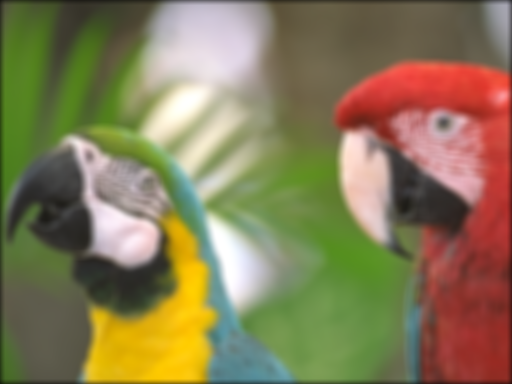

In [17]:
distorted_image_path = 'tid2013/distorted_images/I23_08_5.bmp'
Image.open(distorted_image_path)

In [18]:
distorted_image = np.array(Image.open(distorted_image_path))
distorted_image_grey = rgb2gray(distorted_image)
distorted_image_grey_downsized = cv2.resize(distorted_image_grey,None,fx=1/2,fy=1/2,interpolation=cv2.INTER_CUBIC)
f_distorted = calculate_brisque_features(distorted_image_grey)
f_distorted_downsized = calculate_brisque_features(distorted_image_grey_downsized)
features = np.concatenate((f_distorted,f_distorted_downsized)).reshape(1,-1)
predicted_dmos = regresser.predict(features)[0]
GN_Prob = gn_clf.predict_proba(features)[0][1]
GB_Prob = gb_clf.predict_proba(features)[0][1]
JPEG_Prob = JPEG_clf.predict_proba(features)[0][1]
JPEG2K_Prob = JPEG2K_clf.predict_proba(features)[0][1]
IQ_Score = predicted_dmos*GN_Prob + predicted_dmos*GB_Prob + predicted_dmos*JPEG_Prob + predicted_dmos*JPEG2K_Prob
print(IQ_Score)

51.65011300499328


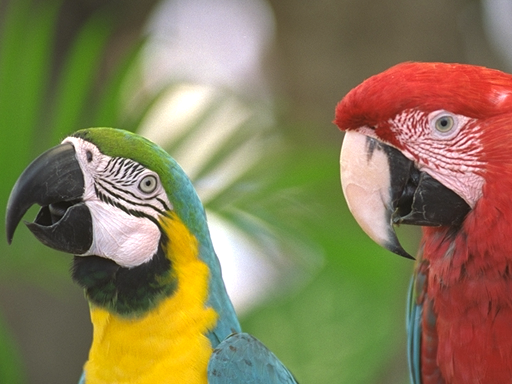

In [19]:
reference_image_path = 'tid2013/reference_images/I23.BMP'
Image.open(reference_image_path)

In [20]:
reference_image = np.array(Image.open(reference_image_path))
reference_image_grey = rgb2gray(reference_image)
reference_image_grey_downsized = cv2.resize(reference_image_grey,None,fx=1/2,fy=1/2,interpolation=cv2.INTER_CUBIC)
f_reference = calculate_brisque_features(reference_image_grey)
f_reference_downsized = calculate_brisque_features(reference_image_grey_downsized)
features = np.concatenate((f_reference,f_reference_downsized)).reshape(1,-1)
predicted_dmos = regresser.predict(features)[0]
GN_Prob = gn_clf.predict_proba(features)[0][1]
GB_Prob = gb_clf.predict_proba(features)[0][1]
JPEG_Prob = JPEG_clf.predict_proba(features)[0][1]
JPEG2K_Prob = JPEG2K_clf.predict_proba(features)[0][1]
IQ_Score = predicted_dmos*GN_Prob + predicted_dmos*GB_Prob + predicted_dmos*JPEG_Prob + predicted_dmos*JPEG2K_Prob
print(IQ_Score)

72.48814995903717


In [ ]:
print('hello')